# 📊 Sequential Recommendation Models — Comparison Analysis
**Farouk Ouledmeriem · Badji Mokhtar University, Annaba · Master's 2 — Database and Decision Systems**

This notebook:
1. Loads every model from `results/`
2. Compares **test metrics** (HR, NDCG, MRR @5/10/20)
3. Compares **grouped metrics** (short / medium / overall sequences)
4. Exports **CSV tables** and **publication-quality PNG figures**
5. Generates a **LaTeX file** (`paper_tables.tex`) ready to paste in your paper

## ⚙️ Cell 1 — Imports & Setup

In [1]:
import os, json, warnings
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from pathlib import Path

warnings.filterwarnings("ignore")
pd.set_option("display.float_format", "{:.4f}".format)
pd.set_option("display.max_columns", 20)

# ── Matplotlib global style ───────────────────────────────────────────────
plt.rcParams.update({
    "figure.dpi":       150,
    "savefig.dpi":      300,
    "font.family":      "DejaVu Sans",
    "font.size":        11,
    "axes.titlesize":   13,
    "axes.labelsize":   11,
    "legend.fontsize":  9,
    "xtick.labelsize":  9,
    "ytick.labelsize":  9,
    "axes.spines.top":  False,
    "axes.spines.right":False,
})

print("✓ All libraries imported successfully.")

✓ All libraries imported successfully.


## ⚙️ Cell 2 — Configuration

In [2]:
# ── Paths ─────────────────────────────────────────────────────────────────
RESULTS_DIR  = Path("../results/100k")          # root results directory
OUTPUT_DIR   = Path("comparison_output")
OUTPUT_DIR.mkdir(exist_ok=True)

# ── Metrics of interest ──────────────────────────────────────────────────
TEST_METRICS = [
    "HR@5",   "NDCG@5",  "MRR@5",
    "HR@10",  "NDCG@10", "MRR@10",
    "HR@20",  "NDCG@20", "MRR@20",
]
GROUP_METRICS = ["HR@10", "NDCG@10", "MRR@10", "HR@20", "NDCG@20", "MRR@20"]
GROUPS        = ["short", "medium", "overall"]

# ── Baseline model (for improvement %) ───────────────────────────────────
BASELINE_MODEL = "bert4rec"

# ── Pretty display names ─────────────────────────────────────────────────
DISPLAY_NAMES = {
    "bert4rec":            "BERT4Rec",
    "sasrec":              "SASRec",
    "gru4rec":             "GRU4Rec",
    "caser":               "Caser",
    "lightgcn":            "LightGCN",
    "tcn_bert4rec":        "TCN-BERT4Rec",
    "tgt_bert4rec":        "TGT-BERT4Rec",
    "bert_hybrid_discrete":"BERT-Hybrid-Discrete",
    "bert_hybrid_fixed":   "BERT-Hybrid-Fixed",
}

print(f"✓ Results directory : {RESULTS_DIR.resolve()}")
print(f"✓ Output directory  : {OUTPUT_DIR.resolve()}")
print(f"✓ Baseline model    : {BASELINE_MODEL}")

✓ Results directory : /home/farouk/length-adaptive/results/100k
✓ Output directory  : /home/farouk/length-adaptive/notebooks/comparison_output
✓ Baseline model    : bert4rec


## 📂 Cell 3 — Load All Models

In [3]:
def load_models(results_dir: Path) -> dict:
    """Scan results/ and load config, results, history for every sub-folder."""
    models = {}
    for folder in sorted(results_dir.iterdir()):
        if not folder.is_dir():
            continue
        name = folder.name
        entry = {"name": name}

        # results.json (required)
        rp = folder / "results.json"
        if not rp.exists():
            print(f"  ⚠  {name}: results.json missing — skipped")
            continue
        with open(rp) as f:
            data = json.load(f)

        # handle test_metrics stored as JSON string or dict
        tm = data.get("test_metrics", {})
        if isinstance(tm, str):
            tm = json.loads(tm)
        entry["test_metrics"] = tm

        # handle grouped_metrics stored as JSON string or dict
        gm = data.get("grouped_metrics", {})
        if isinstance(gm, str):
            gm = json.loads(gm)
        entry["grouped_metrics"] = gm

        entry["best_epoch"]      = data.get("best_epoch")
        entry["best_val_metric"] = data.get("best_val_metric")

        # config.json (optional)
        cp = folder / "config.json"
        if cp.exists():
            with open(cp) as f:
                entry["config"] = json.load(f)

        # history.json (optional)
        hp = folder / "history.json"
        if hp.exists():
            with open(hp) as f:
                entry["history"] = json.load(f)

        models[name] = entry
        print(f"  ✓  Loaded: {name}")

    print(f"\n{'─'*40}")
    print(f"  Total models loaded: {len(models)}")
    return models


MODELS = load_models(RESULTS_DIR)

  ✓  Loaded: bert4rec
  ✓  Loaded: bert_hybrid_discrete
  ✓  Loaded: bert_hybrid_fixed
  ✓  Loaded: caser
  ✓  Loaded: gru4rec
  ✓  Loaded: lightgcn
  ✓  Loaded: sasrec
  ✓  Loaded: tcn_bert4rec
  ✓  Loaded: tgt_bert4rec

────────────────────────────────────────
  Total models loaded: 9


## 📊 Cell 4 — Build Comparison DataFrames

In [4]:
# ── Test metrics table ───────────────────────────────────────────────────
rows_test = []
for name, m in MODELS.items():
    row = {"Model": DISPLAY_NAMES.get(name, name)}
    for metric in TEST_METRICS:
        row[metric] = m["test_metrics"].get(metric, np.nan)
    rows_test.append(row)

df_test = pd.DataFrame(rows_test).set_index("Model")

# ── Grouped metrics tables ───────────────────────────────────────────────
df_groups = {}
for grp in GROUPS:
    rows = []
    for name, m in MODELS.items():
        gm  = m.get("grouped_metrics", {})
        sub = gm.get(grp, {})
        row = {"Model": DISPLAY_NAMES.get(name, name)}
        for metric in GROUP_METRICS:
            row[metric] = sub.get(metric, np.nan)
        row["count"] = int(sub.get("count", 0))
        rows.append(row)
    df_groups[grp] = pd.DataFrame(rows).set_index("Model")

print("── Test Metrics ──────────────────────────────────────────────────────")
display(df_test)

for grp in GROUPS:
    print(f"\n── Group: {grp.upper()} ──────────────────────────────────────────────")
    display(df_groups[grp])

── Test Metrics ──────────────────────────────────────────────────────


,HR@5,NDCG@5,MRR@5,HR@10,NDCG@10,MRR@10,HR@20,NDCG@20,MRR@20
Model,,,,,,,,,
BERT4Rec,0.0565,0.0327,0.0250,0.0949,0.0449,0.0299,0.1844,0.0671,0.0358
BERT-Hybrid-Discrete,0.0512,0.0291,0.0219,0.0853,0.0402,0.0266,0.1535,0.0575,0.0313
BERT-Hybrid-Fixed,0.0501,0.0279,0.0207,0.0864,0.0393,0.0252,0.1727,0.0610,0.0311
Caser,0.0576,0.0369,0.0302,0.1109,0.0540,0.0371,0.1844,0.0726,0.0422
GRU4Rec,0.0341,0.0201,0.0156,0.0650,0.0302,0.0198,0.1077,0.0411,0.0229
LightGCN,0.0320,0.0196,0.0155,0.0682,0.0312,0.0202,0.1194,0.0441,0.0237
SASRec,0.0416,0.0255,0.0202,0.0682,0.0339,0.0235,0.1461,0.0532,0.0286
TCN-BERT4Rec,0.0682,0.0386,0.0290,0.1194,0.0551,0.0358,0.2111,0.0780,0.0419
TGT-BERT4Rec,0.0512,0.0340,0.0284,0.0981,0.0490,0.0345,0.1684,0.0665,0.0391



── Group: SHORT ──────────────────────────────────────────────


,HR@10,NDCG@10,MRR@10,HR@20,NDCG@20,MRR@20,count
Model,,,,,,,
BERT4Rec,0.1860,0.1061,0.0825,0.2907,0.1321,0.0894,86
BERT-Hybrid-Discrete,0.1977,0.0939,0.0630,0.2558,0.1082,0.0667,86
BERT-Hybrid-Fixed,0.1860,0.0864,0.0572,0.3140,0.1190,0.0663,86
Caser,0.1744,0.0921,0.0678,0.2442,0.1093,0.0722,86
GRU4Rec,0.0930,0.0435,0.0287,0.1628,0.0613,0.0337,86
LightGCN,0.1279,0.0624,0.0423,0.2442,0.0917,0.0503,86
SASRec,0.1512,0.0776,0.0543,0.2558,0.1039,0.0614,86
TCN-BERT4Rec,0.1977,0.0937,0.0612,0.3256,0.1252,0.0694,86
TGT-BERT4Rec,0.2209,0.1281,0.1002,0.3256,0.1537,0.1068,86



── Group: MEDIUM ──────────────────────────────────────────────


,HR@10,NDCG@10,MRR@10,HR@20,NDCG@20,MRR@20,count
Model,,,,,,,
BERT4Rec,0.0857,0.0387,0.0246,0.1737,0.0606,0.0304,852
BERT-Hybrid-Discrete,0.1113,0.0528,0.0348,0.2085,0.0773,0.0415,494
BERT-Hybrid-Fixed,0.1073,0.0471,0.0290,0.2126,0.0734,0.0360,494
Caser,0.1045,0.0501,0.0340,0.1784,0.0688,0.0392,852
GRU4Rec,0.0622,0.0289,0.0189,0.1021,0.0391,0.0218,852
LightGCN,0.0622,0.0280,0.0180,0.1068,0.0393,0.0210,852
SASRec,0.0599,0.0295,0.0204,0.1350,0.0481,0.0253,852
TCN-BERT4Rec,0.1296,0.0596,0.0389,0.2409,0.0875,0.0464,494
TGT-BERT4Rec,0.1215,0.0589,0.0404,0.2065,0.0801,0.0460,494



── Group: OVERALL ──────────────────────────────────────────────


,HR@10,NDCG@10,MRR@10,HR@20,NDCG@20,MRR@20,count
Model,,,,,,,
BERT4Rec,0.0949,0.0449,0.0299,0.1844,0.0671,0.0358,938
BERT-Hybrid-Discrete,0.0853,0.0402,0.0266,0.1535,0.0575,0.0313,938
BERT-Hybrid-Fixed,0.0864,0.0393,0.0252,0.1727,0.0610,0.0311,938
Caser,0.1109,0.0540,0.0371,0.1844,0.0726,0.0422,938
GRU4Rec,0.0650,0.0302,0.0198,0.1077,0.0411,0.0229,938
LightGCN,0.0682,0.0312,0.0202,0.1194,0.0441,0.0237,938
SASRec,0.0682,0.0339,0.0235,0.1461,0.0532,0.0286,938
TCN-BERT4Rec,0.1194,0.0551,0.0358,0.2111,0.0780,0.0419,938
TGT-BERT4Rec,0.0981,0.0490,0.0345,0.1684,0.0665,0.0391,938


## 🏆 Cell 5 — Best Model per Metric

In [5]:
print("═"*55)
print("  BEST MODEL PER TEST METRIC")
print("═"*55)
for col in df_test.columns:
    best_idx = df_test[col].idxmax()
    best_val = df_test[col].max()
    print(f"  {col:<10}  →  {best_idx:<25}  {best_val:.4f}")

print()
for grp in GROUPS:
    print(f"═"*55)
    print(f"  BEST MODEL — {grp.upper()} sequences")
    print(f"═"*55)
    for col in GROUP_METRICS:
        best_idx = df_groups[grp][col].idxmax()
        best_val = df_groups[grp][col].max()
        print(f"  {col:<10}  →  {best_idx:<25}  {best_val:.4f}")
    print()

═══════════════════════════════════════════════════════
  BEST MODEL PER TEST METRIC
═══════════════════════════════════════════════════════
  HR@5        →  TCN-BERT4Rec               0.0682
  NDCG@5      →  TCN-BERT4Rec               0.0386
  MRR@5       →  Caser                      0.0302
  HR@10       →  TCN-BERT4Rec               0.1194
  NDCG@10     →  TCN-BERT4Rec               0.0551
  MRR@10      →  Caser                      0.0371
  HR@20       →  TCN-BERT4Rec               0.2111
  NDCG@20     →  TCN-BERT4Rec               0.0780
  MRR@20      →  Caser                      0.0422

═══════════════════════════════════════════════════════
  BEST MODEL — SHORT sequences
═══════════════════════════════════════════════════════
  HR@10       →  TGT-BERT4Rec               0.2209
  NDCG@10     →  TGT-BERT4Rec               0.1281
  MRR@10      →  TGT-BERT4Rec               0.1002
  HR@20       →  TCN-BERT4Rec               0.3256
  NDCG@20     →  TGT-BERT4Rec               0.1537
 

## 📈 Cell 6 — Relative Improvement Over Baseline

In [6]:
baseline_display = DISPLAY_NAMES.get(BASELINE_MODEL, BASELINE_MODEL)

if baseline_display in df_test.index:
    baseline_row = df_test.loc[baseline_display]
    df_imp = ((df_test - baseline_row) / baseline_row * 100).round(2)
    df_imp.columns = [f"Δ {c} (%)" for c in df_imp.columns]

    print(f"Relative improvement (%) compared to {baseline_display}:")
    display(df_imp)

    # Save
    df_imp.to_csv(OUTPUT_DIR / "test_metrics_improvements.csv")
    print(f"\n✓ Saved → {OUTPUT_DIR}/test_metrics_improvements.csv")
else:
    print(f"⚠  Baseline model '{baseline_display}' not found in results.")
    print(f"   Available models: {list(df_test.index)}")

Relative improvement (%) compared to BERT4Rec:


,Δ HR@5 (%),Δ NDCG@5 (%),Δ MRR@5 (%),Δ HR@10 (%),Δ NDCG@10 (%),Δ MRR@10 (%),Δ HR@20 (%),Δ NDCG@20 (%),Δ MRR@20 (%)
Model,,,,,,,,,
BERT4Rec,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
BERT-Hybrid-Discrete,-9.4300,-11.1600,-12.5000,-10.1100,-10.3900,-11.1300,-16.7600,-14.3600,-12.4900
BERT-Hybrid-Fixed,-11.3200,-14.7000,-17.2600,-8.9900,-12.4200,-15.6500,-6.3600,-9.1400,-13.1300
Caser,1.8900,12.9000,20.7400,16.8500,20.1800,24.0600,0.0000,8.0800,17.9100
GRU4Rec,-39.6200,-38.4600,-37.5700,-31.4600,-32.7300,-33.7400,-41.6200,-38.7700,-36.1000
LightGCN,-43.4000,-40.0300,-37.9300,-28.0900,-30.5700,-32.4800,-35.2600,-34.3400,-33.7400
SASRec,-26.4200,-22.0500,-19.3200,-28.0900,-24.4900,-21.3600,-20.8100,-20.7100,-19.9800
TCN-BERT4Rec,20.7500,17.9900,15.9800,25.8400,22.6700,19.5900,14.4500,16.2300,17.1600
TGT-BERT4Rec,-9.4300,3.8400,13.4200,3.3700,9.0300,15.1500,-8.6700,-0.9600,9.2800



✓ Saved → comparison_output/test_metrics_improvements.csv


## 🔥 Cell 7 — All Metrics Heatmap

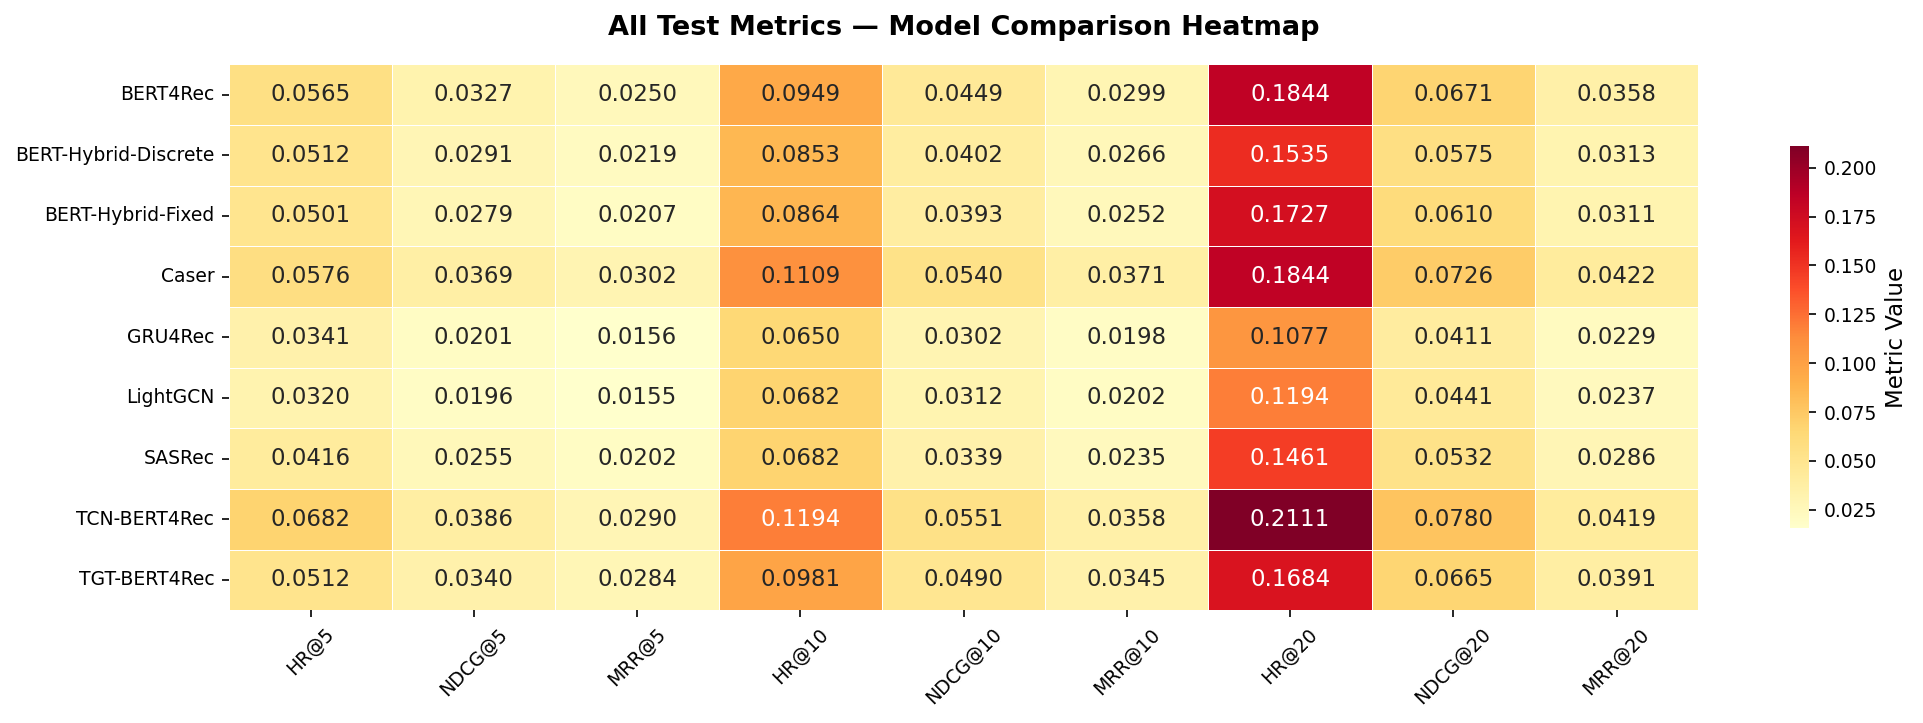

✓ Saved → comparison_output/heatmap_all_test_metrics.png


In [7]:
fig, ax = plt.subplots(figsize=(14, max(4, len(df_test)*0.55)))

sns.heatmap(
    df_test,
    annot=True, fmt=".4f",
    cmap="YlOrRd",
    linewidths=0.4, linecolor="white",
    cbar_kws={"shrink": 0.7, "label": "Metric Value"},
    ax=ax
)
ax.set_title("All Test Metrics — Model Comparison Heatmap", pad=14, fontweight="bold")
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(axis="x", rotation=45)
ax.tick_params(axis="y", rotation=0)

plt.tight_layout()
out = OUTPUT_DIR / "heatmap_all_test_metrics.png"
plt.savefig(out, bbox_inches="tight")
plt.show()
print(f"✓ Saved → {out}")

## 📊 Cell 8 — Bar Charts: HR / NDCG / MRR

In [8]:
def bar_chart(df, cols, title, filename, palette="tab10"):
    """Side-by-side bar chart for a list of columns."""
    x      = np.arange(len(df))
    n      = len(cols)
    width  = 0.8 / n
    colors = plt.cm.get_cmap(palette, n).colors if n <= 10 else None

    fig, ax = plt.subplots(figsize=(max(10, len(df)*1.2), 5))
    for i, col in enumerate(cols):
        bars = ax.bar(
            x + (i - n/2 + 0.5) * width,
            df[col].values,
            width=width * 0.9,
            label=col,
            color=colors[i] if colors is not None else None,  # ✅ FIX
        )
        # value labels on top
        for bar in bars:
            h = bar.get_height()
            if not np.isnan(h):
                ax.text(
                    bar.get_x() + bar.get_width() / 2, h + 0.001,
                    f"{h:.4f}", ha="center", va="bottom",
                    fontsize=6.5, rotation=90
                )
    ax.set_xticks(x)
    ax.set_xticklabels(df.index, rotation=35, ha="right")
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.3f"))
    ax.set_title(title, fontweight="bold", pad=12)
    ax.set_ylabel("Score")
    ax.legend(loc="upper right", framealpha=0.9)
    plt.tight_layout()
    out = OUTPUT_DIR / filename
    plt.savefig(out, bbox_inches="tight")
    plt.show()
    print(f"✓ Saved → {out}")

## 🔵 Cell 9 — Group-wise Comparison Charts

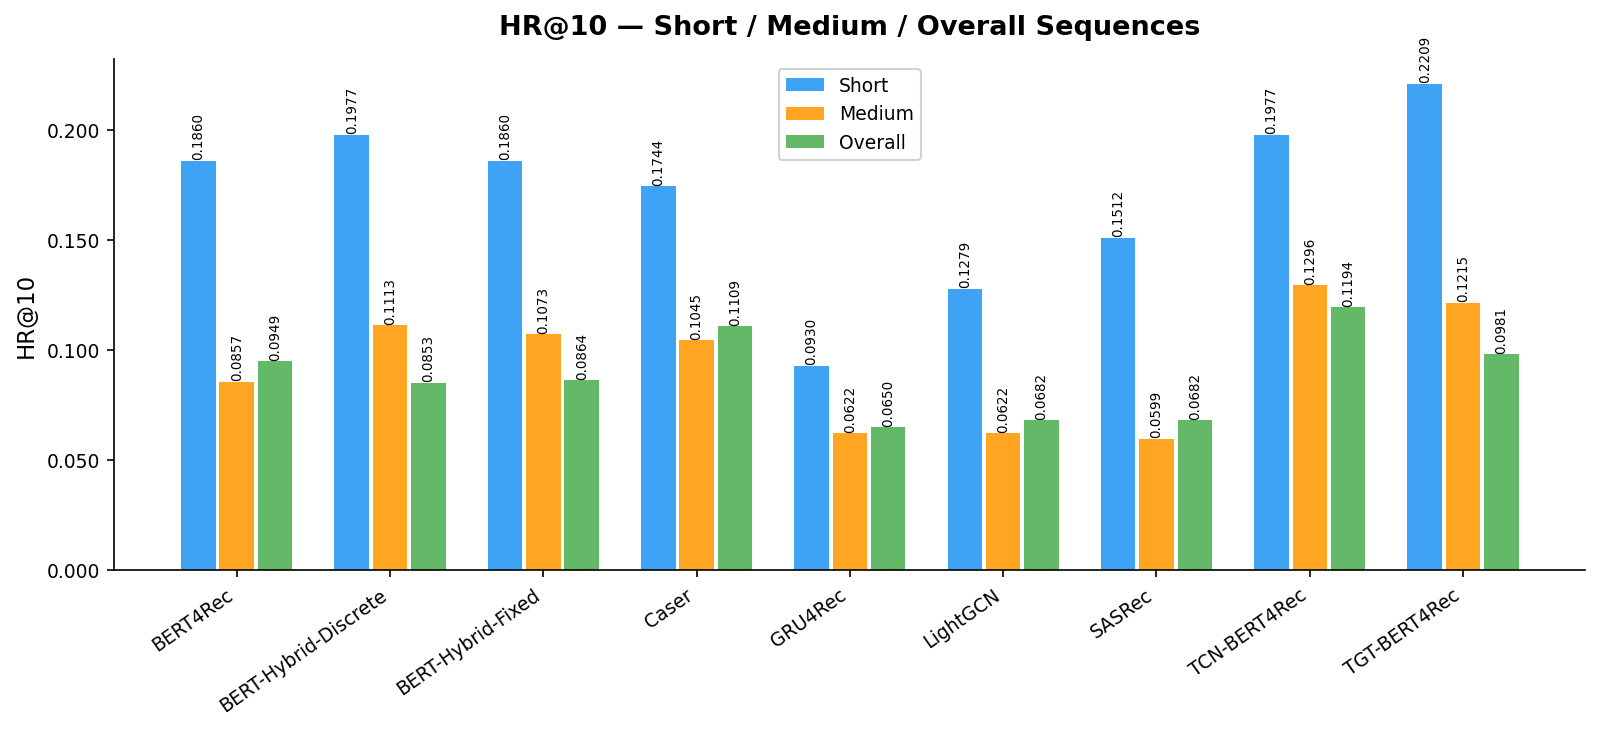

✓ Saved → comparison_output/group_HR10.png


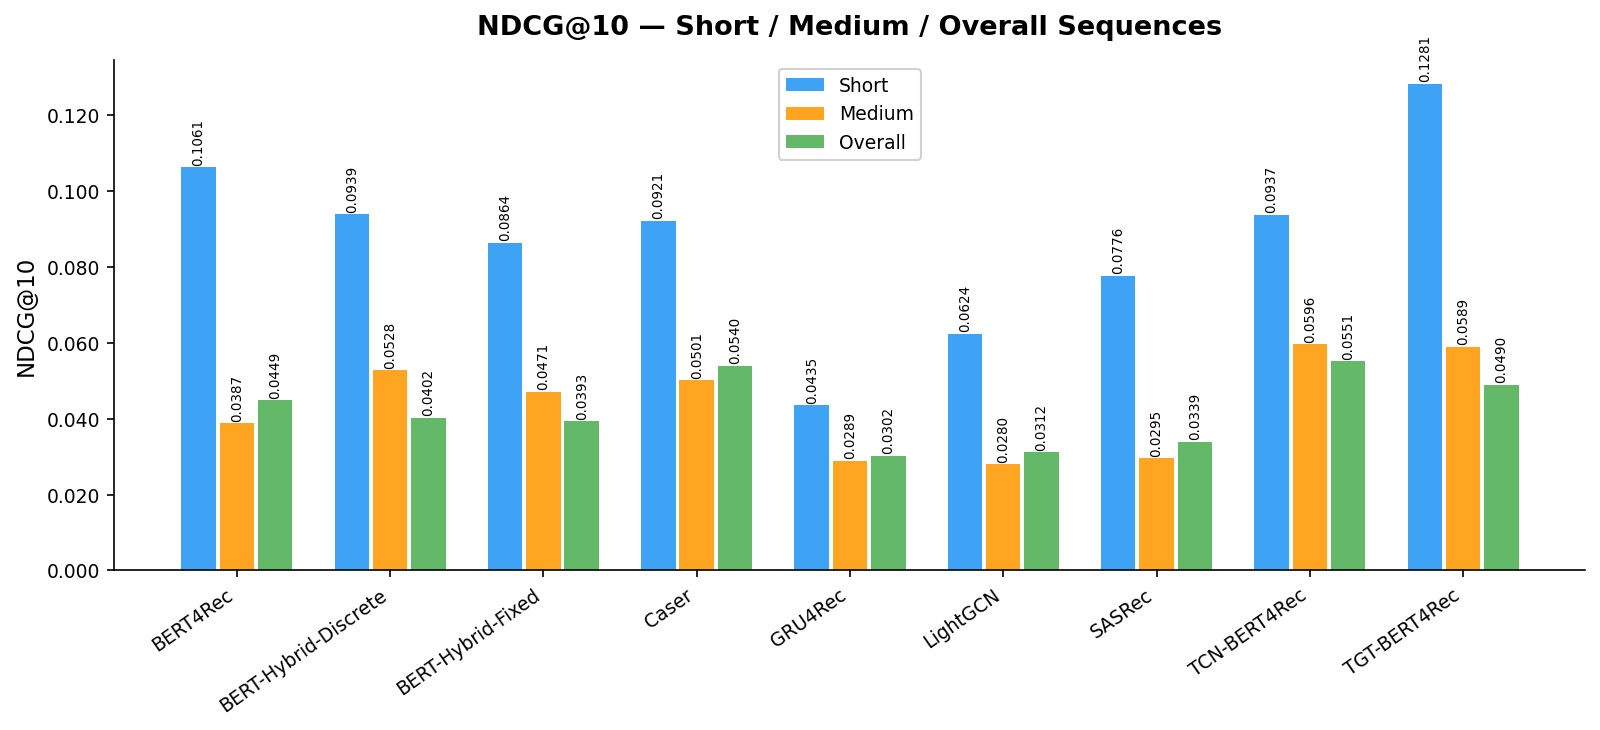

✓ Saved → comparison_output/group_NDCG10.png


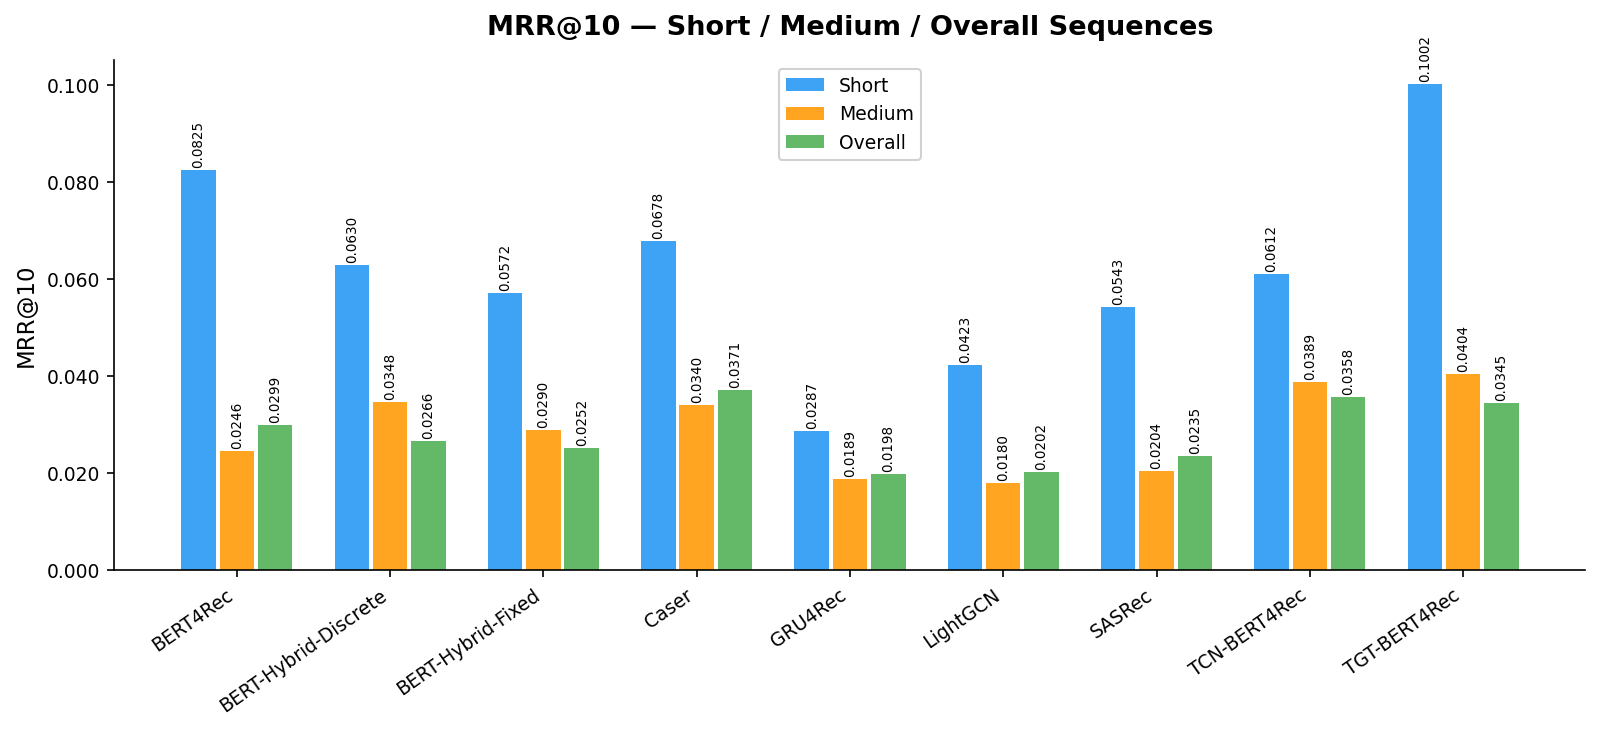

✓ Saved → comparison_output/group_MRR10.png


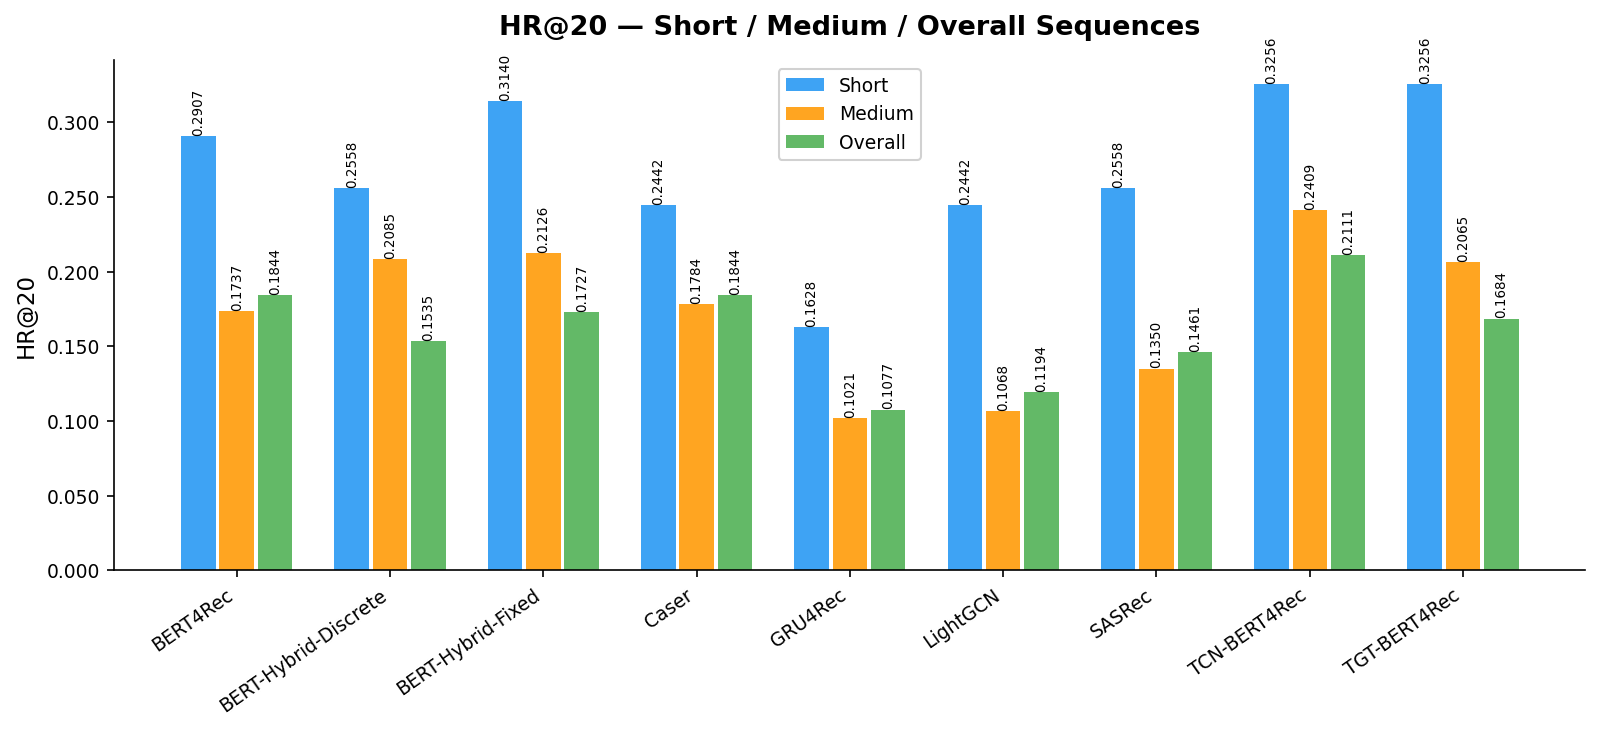

✓ Saved → comparison_output/group_HR20.png


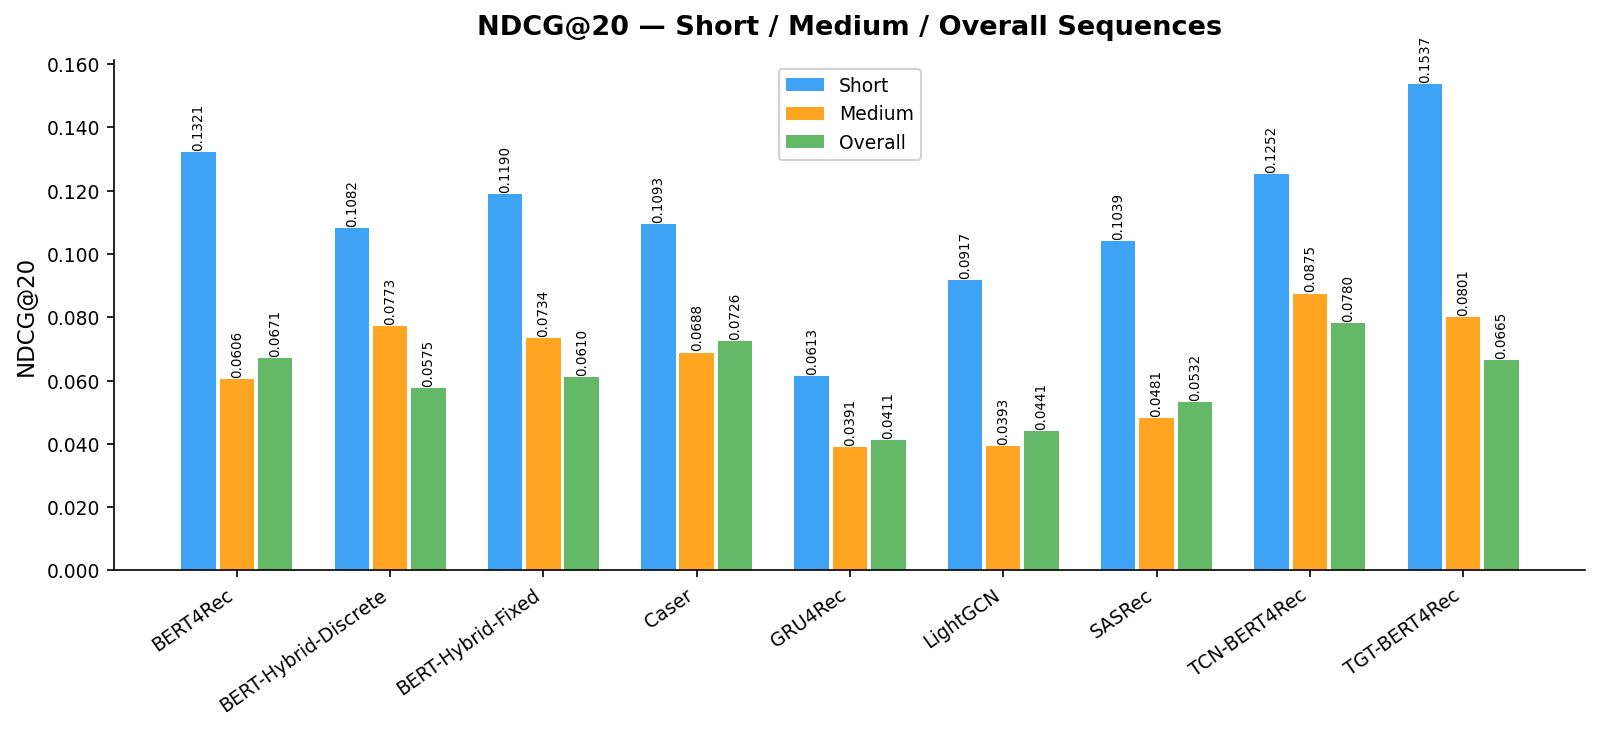

✓ Saved → comparison_output/group_NDCG20.png


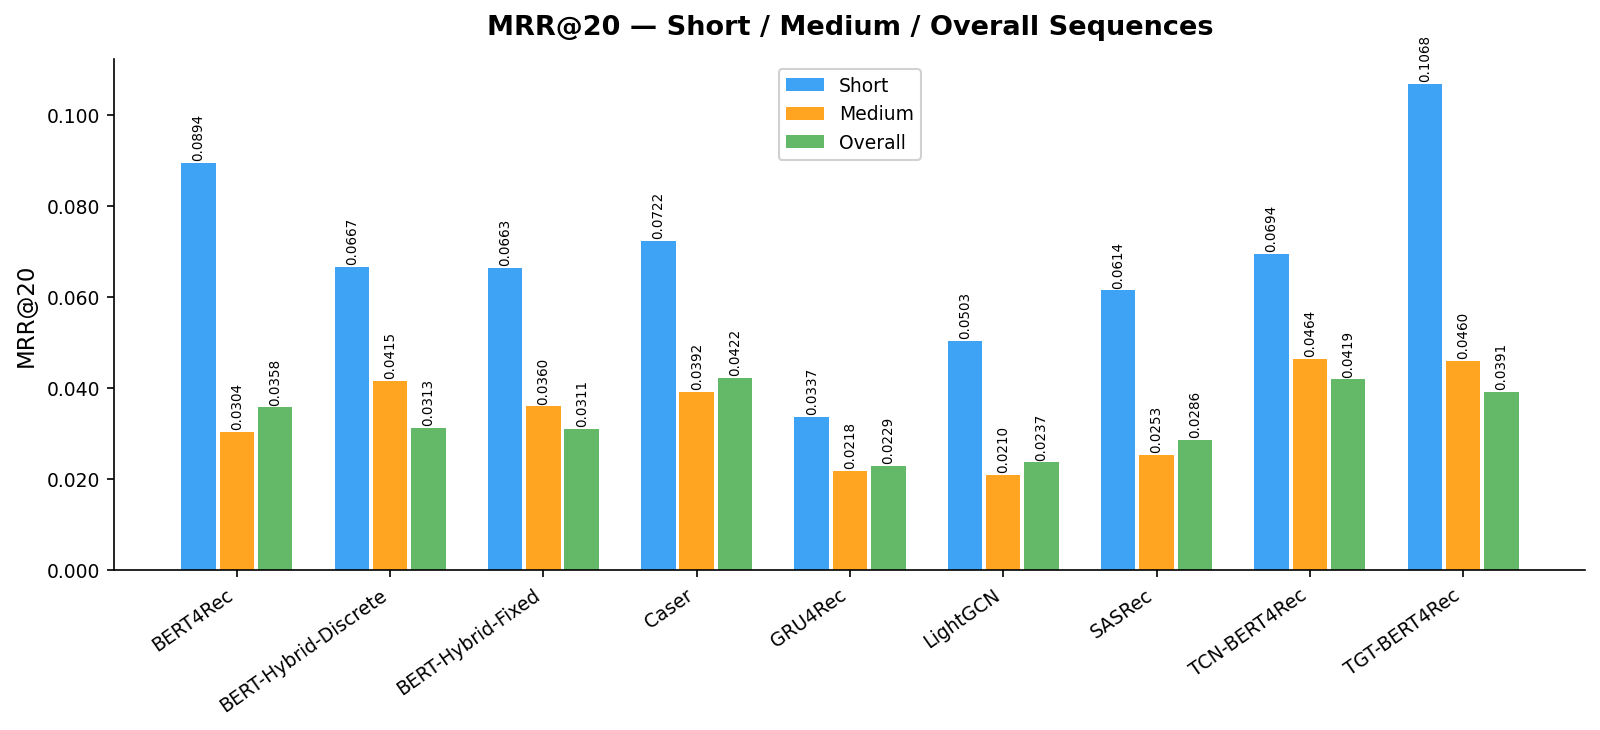

✓ Saved → comparison_output/group_MRR20.png


In [9]:
def group_bar(metric, title_suffix=""):
    """
    For a single metric, plot short / medium / overall side by side per model.
    """
    models_disp = list(df_groups["overall"].index)
    x = np.arange(len(models_disp))
    w = 0.25
    grp_colors = {"short": "#2196F3", "medium": "#FF9800", "overall": "#4CAF50"}

    fig, ax = plt.subplots(figsize=(max(10, len(models_disp)*1.2), 5))
    for i, grp in enumerate(GROUPS):
        vals = [df_groups[grp].loc[m, metric] if m in df_groups[grp].index else np.nan
                for m in models_disp]
        bars = ax.bar(
            x + (i - 1) * w, vals,
            width=w * 0.9,
            label=grp.capitalize(),
            color=grp_colors[grp],
            alpha=0.87
        )
        for bar, v in zip(bars, vals):
            if not np.isnan(v):
                ax.text(
                    bar.get_x() + bar.get_width() / 2, v + 0.0005,
                    f"{v:.4f}", ha="center", va="bottom",
                    fontsize=6.5, rotation=90
                )
    ax.set_xticks(x)
    ax.set_xticklabels(models_disp, rotation=35, ha="right")
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.3f"))
    ax.set_title(f"{metric} — Short / Medium / Overall Sequences{title_suffix}",
                 fontweight="bold", pad=12)
    ax.set_ylabel(metric)
    ax.legend(framealpha=0.9)
    plt.tight_layout()
    tag = metric.replace("@", "")
    out = OUTPUT_DIR / f"group_{tag}.png"
    plt.savefig(out, bbox_inches="tight")
    plt.show()
    print(f"✓ Saved → {out}")

for m in GROUP_METRICS:
    group_bar(m)

## 📉 Cell 10 — Training Loss Curves

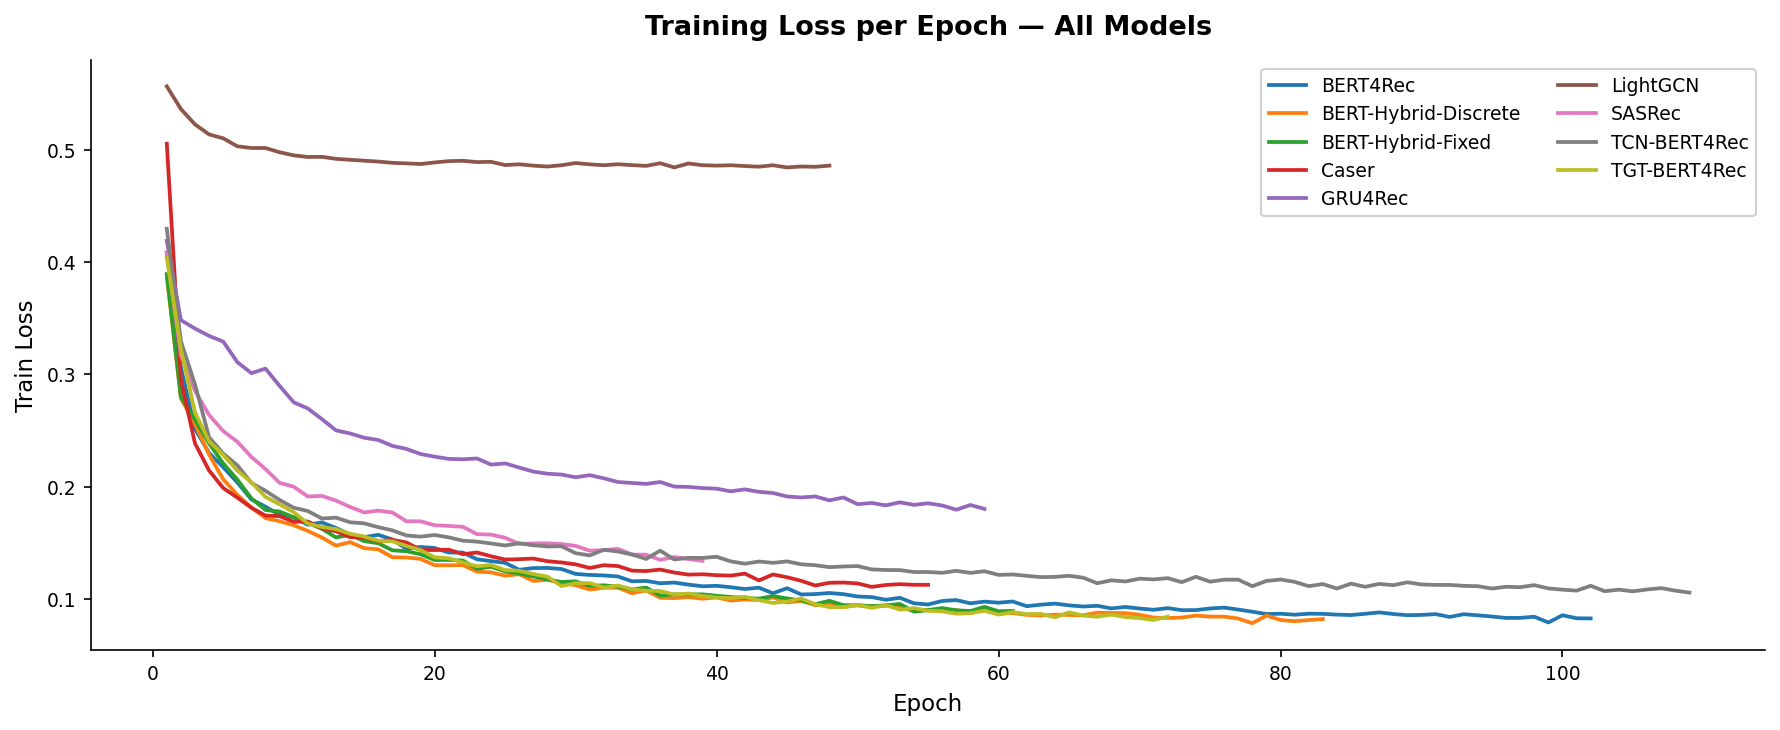

✓ Saved → comparison_output/training_loss_curves.png


In [10]:
fig, ax = plt.subplots(figsize=(12, 5))

for name, m in MODELS.items():
    hist = m.get("history")
    if hist and "train_loss" in hist:
        loss = hist["train_loss"]
        label = DISPLAY_NAMES.get(name, name)
        ax.plot(range(1, len(loss)+1), loss, label=label, linewidth=1.8)

ax.set_title("Training Loss per Epoch — All Models", fontweight="bold", pad=12)
ax.set_xlabel("Epoch")
ax.set_ylabel("Train Loss")
ax.legend(loc="upper right", ncol=2, framealpha=0.9)
plt.tight_layout()
out = OUTPUT_DIR / "training_loss_curves.png"
plt.savefig(out, bbox_inches="tight")
plt.show()
print(f"✓ Saved → {out}")

## 📈 Cell 11 — Validation NDCG@10 Curves

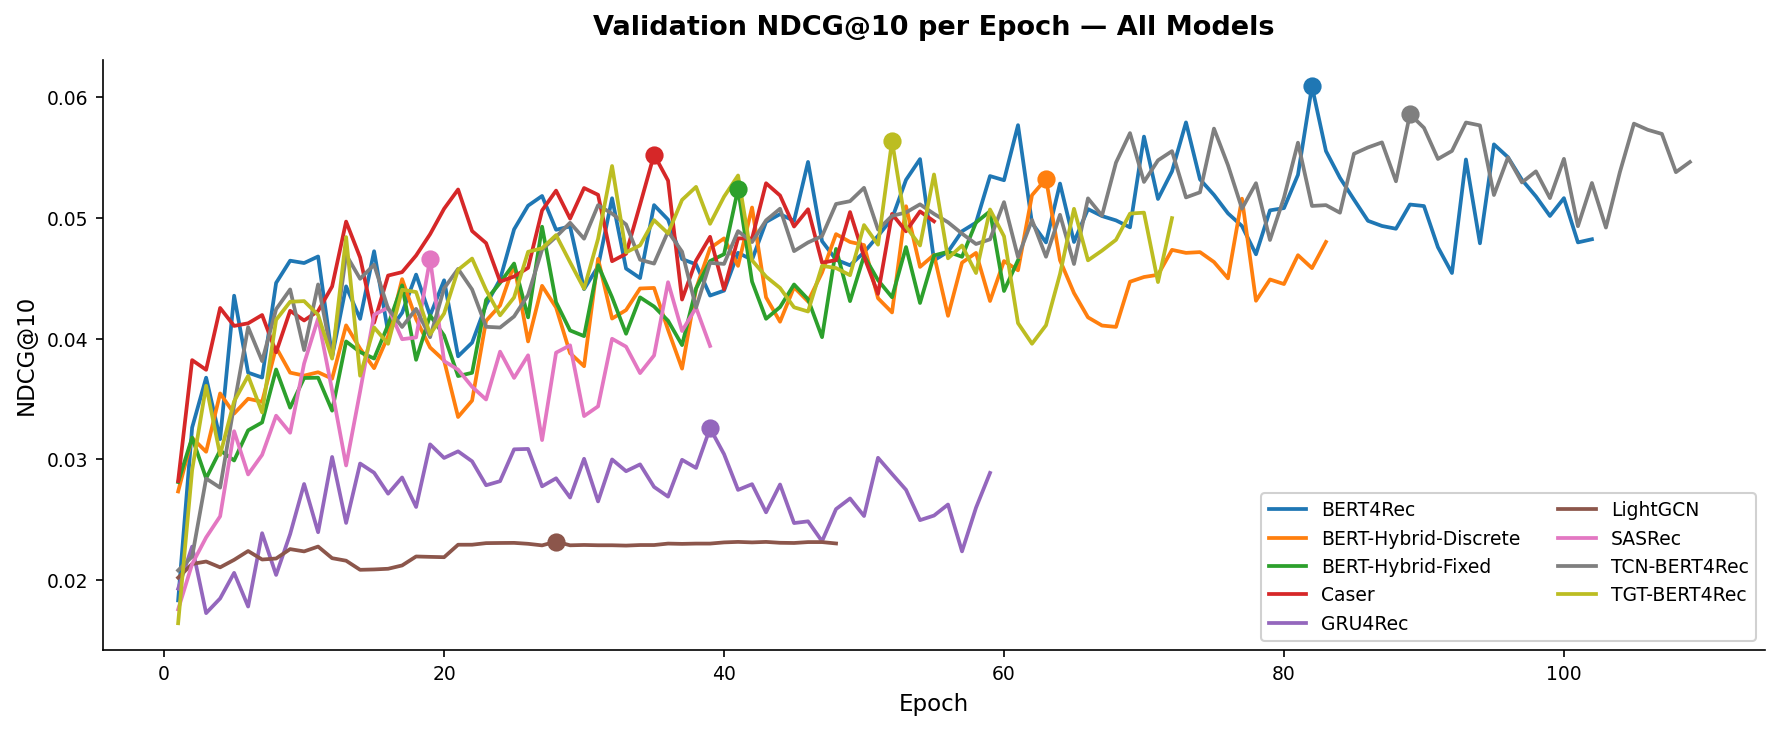

✓ Saved → comparison_output/val_ndcg10_curves.png


In [11]:
fig, ax = plt.subplots(figsize=(12, 5))

for name, m in MODELS.items():
    hist = m.get("history")
    if hist and "val_metrics" in hist:
        vals = [v.get("NDCG@10", np.nan) for v in hist["val_metrics"]]
        label = DISPLAY_NAMES.get(name, name)
        ax.plot(range(1, len(vals)+1), vals, label=label, linewidth=1.8)
        # mark best epoch
        best_ep = m.get("best_epoch")
        if best_ep and 1 <= best_ep <= len(vals):
            ax.scatter(best_ep, vals[best_ep-1], s=60, zorder=5)

ax.set_title("Validation NDCG@10 per Epoch — All Models", fontweight="bold", pad=12)
ax.set_xlabel("Epoch")
ax.set_ylabel("NDCG@10")
ax.legend(loc="lower right", ncol=2, framealpha=0.9)
plt.tight_layout()
out = OUTPUT_DIR / "val_ndcg10_curves.png"
plt.savefig(out, bbox_inches="tight")
plt.show()
print(f"✓ Saved → {out}")

## 📋 Cell 12 — Best Epoch & Val Metric Summary

In [12]:
rows = []
for name, m in MODELS.items():
    rows.append({
        "Model":          DISPLAY_NAMES.get(name, name),
        "Best Epoch":     m.get("best_epoch"),
        "Best Val NDCG@10": m.get("best_val_metric"),
    })
df_summary = pd.DataFrame(rows).set_index("Model")
display(df_summary)

df_summary.to_csv(OUTPUT_DIR / "training_summary.csv")
print(f"\n✓ Saved → {OUTPUT_DIR}/training_summary.csv")

,Best Epoch,Best Val NDCG@10
Model,,
BERT4Rec,82,0.0609
BERT-Hybrid-Discrete,63,NaN
BERT-Hybrid-Fixed,41,NaN
Caser,35,0.0553
GRU4Rec,39,0.0326
LightGCN,28,0.0232
SASRec,19,0.0466
TCN-BERT4Rec,89,NaN
TGT-BERT4Rec,52,NaN



✓ Saved → comparison_output/training_summary.csv


## ⚙️ Cell 13 — Hyperparameter / Config Table

In [13]:
cfg_keys = ["d_model", "n_heads", "n_blocks", "n_layers",
             "dropout", "max_len", "epochs", "batch_size", "lr",
             "weight_decay", "patience"]

rows = []
for name, m in MODELS.items():
    cfg = m.get("config", {})
    row = {"Model": DISPLAY_NAMES.get(name, name)}
    for k in cfg_keys:
        row[k] = cfg.get(k, "—")
    rows.append(row)

df_cfg = pd.DataFrame(rows).set_index("Model")
display(df_cfg)

df_cfg.to_csv(OUTPUT_DIR / "hyperparameters.csv")
print(f"\n✓ Saved → {OUTPUT_DIR}/hyperparameters.csv")

,d_model,n_heads,n_blocks,n_layers,dropout,max_len,epochs,batch_size,lr,weight_decay,patience
Model,,,,,,,,,,,
BERT4Rec,64,2,2,1,0.2000,50,200,256,0.0010,0.0000,20
BERT-Hybrid-Discrete,64,2,2,—,0.2000,200,200,256,0.0010,0.0000,20
BERT-Hybrid-Fixed,64,2,2,—,0.2000,200,200,256,0.0010,0.0000,20
Caser,64,2,2,1,0.2000,50,200,256,0.0010,0.0000,20
GRU4Rec,64,2,2,1,0.2000,50,200,256,0.0010,0.0000,20
LightGCN,64,2,2,1,0.2000,50,200,256,0.0010,0.0000,20
SASRec,64,2,2,1,0.2000,50,200,256,0.0010,0.0000,20
TCN-BERT4Rec,64,2,2,—,0.2000,200,200,256,0.0010,0.0000,20
TGT-BERT4Rec,64,2,2,—,0.2000,200,200,256,0.0010,0.0000,20



✓ Saved → comparison_output/hyperparameters.csv


## 💾 Cell 14 — Export All CSVs

In [14]:
df_test.to_csv(OUTPUT_DIR / "test_metrics.csv")
print(f"✓ test_metrics.csv")

for grp in GROUPS:
    fname = OUTPUT_DIR / f"group_metrics_{grp}.csv"
    df_groups[grp].to_csv(fname)
    print(f"✓ group_metrics_{grp}.csv")

print(f"\nAll CSV files saved to: {OUTPUT_DIR.resolve()}")

✓ test_metrics.csv
✓ group_metrics_short.csv
✓ group_metrics_medium.csv
✓ group_metrics_overall.csv

All CSV files saved to: /home/farouk/length-adaptive/notebooks/comparison_output


## 📝 Cell 15 — Generate LaTeX Tables for the Paper

In [15]:
def df_to_latex(df, caption, label, cols=None, highlight_best=True):
    \"\"\"Convert a DataFrame to a booktabs LaTeX table string.\"\"\"
    if cols:
        sub = df[cols].copy()
    else:
        sub = df.copy()

    # identify best value column-wise
    best = {}
    if highlight_best:
        for c in sub.columns:
            try:
                best[c] = sub[c].idxmax()
            except Exception:
                pass

    col_fmt = "l" + "c" * len(sub.columns)
    header  = " & ".join(["\\textbf{" + c.replace("@", "\\@").replace("_","\_") + "}"
                           for c in sub.columns])

    lines = []
    lines.append(r"\begin{table}[htbp]")
    lines.append(r"\centering")
    lines.append(f"\\caption{{{caption}}}")
    lines.append(f"\\label{{{label}}}")
    lines.append(f"\\begin{{tabular}}{{@{{}} {col_fmt} @{{}}}}")
    lines.append(r"\toprule")
    lines.append(f"\\textbf{{Model}} & {header} \\\\")
    lines.append(r"\midrule")

    for idx, row in sub.iterrows():
        cells_tex = []
        for c, v in zip(sub.columns, row.values):
            if isinstance(v, float) and not np.isnan(v):
                s = f"{v:.4f}"
                if highlight_best and best.get(c) == idx:
                    s = f"\\textbf{{{s}}}"
            else:
                s = str(v) if not (isinstance(v, float) and np.isnan(v)) else "—"
            cells_tex.append(s)
        lines.append(f"{idx} & " + " & ".join(cells_tex) + " \\\\")

    lines.append(r"\bottomrule")
    lines.append(r"\end{tabular}")
    lines.append(r"\end{table}")
    return "\n".join(lines)


# ── Build all tables ──────────────────────────────────────────────────────
tables = []

tables.append("% ── preamble required: \\usepackage{booktabs}\n")

tables.append(df_to_latex(
    df_test,
    caption="Overall test-set performance on MovieLens-1M. Best results per column in \\textbf{bold}.",
    label="tab:test_metrics_full",
))

tables.append(df_to_latex(
    df_test[["HR@10", "NDCG@10", "MRR@10", "HR@20", "NDCG@20", "MRR@20"]],
    caption="Test-set performance (@10 and @20). Best results in \\textbf{bold}.",
    label="tab:test_metrics_main",
))

for grp in GROUPS:
    tables.append(df_to_latex(
        df_groups[grp].drop(columns=["count"], errors="ignore"),
        caption=f"Group-wise performance — \\textit{{{grp.capitalize()}}} sequences "
                f"(count = {df_groups[grp]['count'].iloc[0] if 'count' in df_groups[grp].columns else 'N/A'}).",
        label=f"tab:group_{grp}",
    ))

latex_out = "\n\n% " + "─"*60 + "\n\n".join(tables)

tex_path = OUTPUT_DIR / "paper_tables.tex"
with open(tex_path, "w", encoding="utf-8") as f:
    f.write(latex_out)

print(latex_out)
print(f"\n✓ Saved → {tex_path}")


SyntaxError: unexpected character after line continuation character (1559502338.py, line 2)

## ✅ Cell 16 — Final Summary

In [ ]:
print("═"*60)
print("  ANALYSIS COMPLETE")
print("═"*60)

files = list(OUTPUT_DIR.iterdir())
for f in sorted(files):
    size = f.stat().st_size
    print(f"  {'[PNG]' if f.suffix=='.png' else '[CSV]' if f.suffix=='.csv' else '[TEX]':6}  "
          f"{f.name:<40}  {size/1024:6.1f} KB")

print()
print(f"  Total files generated : {len(files)}")
print(f"  Output directory      : {OUTPUT_DIR.resolve()}")
print()
print("  Use paper_tables.tex in your LaTeX document.")
print("  PNG figures are at 300 DPI — publication-ready.")
print("═"*60)